In [1]:
# Using a basic network in Nengo

import matplotlib.pyplot as plt
import nengo
from nengo.utils.matplotlib import rasterplot
import numpy as np

def generate(scale=1, weights=None, seed=0):
    with nengo.Network(seed=seed) as net:
        input = nengo.Node(lambda t: t)
        output = nengo.Node(size_in=1)
        ens = nengo.Ensemble(
            n_neurons=100, dimensions=1,
            neuron_type=nengo.RectifiedLinear(amplitude=1/scale),
            bias=nengo.dists.Choice([0]),
            gain=nengo.dists.Choice([scale])
        )
        nengo.Connection(input, ens)
        if weights is not None:
            net.conn = nengo.Connection(ens.neurons, output, transform=weights)
        else:
            net.conn = nengo.Connection(ens, output)
        net.probe = nengo.Probe(output)
    return net

seed = np.random.randint(1e5)
print('seed: ', seed)

time = 1
net_noscale = generate(seed=seed)
with nengo.Simulator(net_noscale) as sim_noscale:
    sim_noscale.run(time)
    data_noscale = sim_noscale.data[net_noscale.probe]
    weights = sim_noscale.signals[sim_noscale.model.sig[net_noscale.conn]['weights']]

net_scale = generate(scale=100, weights=weights, seed=seed)
with nengo.Simulator(net_scale) as sim_scale:
    sim_scale.run(time)
    data_scale = sim_scale.data[net_scale.probe]

plt.plot(data_noscale)
plt.plot(data_scale)

seed:  72340


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Train on 900 samples
900/900 [==============================] - 5s 6ms/sample - loss: 7490589.6300 - probe_loss: 7490579.5000
Train on 900 samples
900/900 [==============================] - 5s 5ms/sample - loss: 26.1325 - probe_loss: 26.1325
Train on 900 samples
900/900 [==============================] - 5s 5ms/sample - loss: 27.0220 - probe_loss: 27.0220
(100, 1, 20)


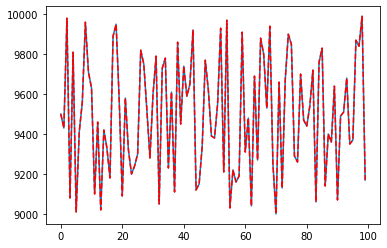

In [2]:
# Using a converted Keras network in NengoDL

import nengo_dl
import tensorflow as tf

input = tf.keras.Input(shape=(1))
relu_layer = tf.keras.layers.Activation(tf.nn.relu)
relu_out = relu_layer(input)

dense_layer = tf.keras.layers.Dense(
    units=20,
    use_bias=False,
)
dense_out = dense_layer(relu_out)

model = tf.keras.Model(inputs=input, outputs=dense_out)
converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: nengo.RectifiedLinear()},
)
net = converter.net
nengo_input = converter.inputs[input]
nengo_output = converter.outputs[dense_out]
nengo_relu = converter.layer_map[relu_layer][0][0]

nengo_relu.ensemble.gain = nengo.dists.Choice([1])

with converter.net as net:
    net.config[nengo_relu.ensemble.neurons].trainable = False
    
with nengo_dl.Simulator(net) as sim:
    def loss_func(y_true, y_pred):
        return (y_true - tf.reduce_sum(y_pred))**2
    sim.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={nengo_output: loss_func},
    )
    
    data_input = np.arange(0, 1000).reshape(1000, 1, 1)
    train_size = int(data_input.shape[0] * .9)
    test_indices = np.random.permutation(range(train_size, data_input.shape[0]))
    for ii in range(3):
        indices = np.random.permutation(range(train_size))
        sim.fit(
            {nengo_input: data_input[indices]},
            {nengo_output: data_input[indices] * 10},
            epochs=1,
        )
    sim.save_params('params')
    
    data = sim.predict({nengo_input: data_input[test_indices]})

print(data[nengo_output].shape)
plt.plot(np.sum(data[nengo_output], axis=2).squeeze())
plt.plot(np.sum(data_input[test_indices], axis=2).squeeze() * 10, 'r--')

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
(100, 1, 20)


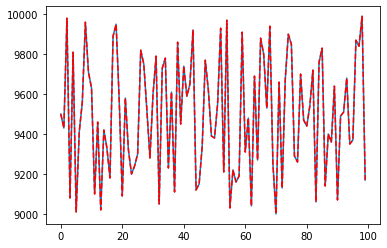

In [3]:
gain_scale = 1000

converter = nengo_dl.Converter(
    model,
    swap_activations={
        tf.nn.relu: nengo.SpikingRectifiedLinear(amplitude=1/gain_scale)
    }
)

net = converter.net
nengo_input = converter.inputs[input]
nengo_output = converter.outputs[dense_out]
nengo_relu = converter.layer_map[relu_layer][0][0]

nengo_relu.ensemble.gain = nengo.dists.Choice([gain_scale])

with nengo_dl.Simulator(net) as sim:
    sim.load_params('params')
    data = sim.predict({nengo_input: data_input[test_indices]})
    
print(data[nengo_output].shape)
plt.plot(np.sum(data[nengo_output], axis=2).squeeze())
plt.plot(np.sum(data_input[test_indices], axis=2).squeeze() * 10, 'r--')

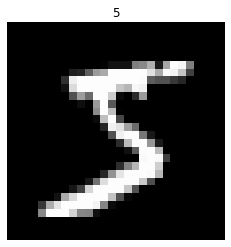

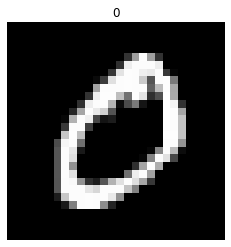

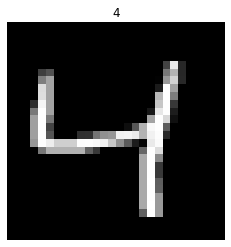

In [4]:
# load in MNIST dataset for testing convnets

%matplotlib inline

from urllib.request import urlretrieve

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.mnist.load_data())

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

for i in range(3):
    plt.figure()
    plt.imshow(np.reshape(train_images[i], (28, 28)),
               cmap="gray")
    plt.axis('off')
    plt.title(str(train_labels[i]));
    
# add single timestep to training data
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps.
n_steps = 30
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))

minibatch_size = 200

In [5]:
# Using a converted ConvNet Keras network in NengoDL

tf.random.set_seed(0)
input = tf.keras.Input(shape=(28, 28, 1), batch_size=minibatch_size)

conv1 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    use_bias=False,
    activation=tf.nn.relu,
)
conv1_out = conv1(input)

flatten = tf.keras.layers.Flatten()(conv1_out)

dense = tf.keras.layers.Dense(units=10, use_bias=False)
dense_out = dense(flatten)

model = tf.keras.Model(inputs=input, outputs=dense_out)
converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: nengo.RectifiedLinear()},
)
net = converter.net
nengo_input = converter.inputs[input]
nengo_output = converter.outputs[dense_out]
nengo_conv1 = converter.layer_map[conv1][0][0]

nengo_conv1.ensemble.gain = nengo.dists.Choice([1])
with converter.net as net:
    net.config[nengo_conv1.ensemble.neurons].trainable = False
    
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size, seed=0)

def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(
        y_true[:, -1], y_pred[:, -1])

sim.compile(loss={nengo_output: classification_accuracy})
print("accuracy before training:",
      sim.evaluate(test_images, {nengo_output: test_labels}, verbose=0)["loss"])

# run training
sim.compile(
    optimizer=tf.optimizers.RMSprop(0.001),
    loss={nengo_output: tf.losses.SparseCategoricalCrossentropy(from_logits=True)}
)
sim.fit(train_images, {nengo_output: train_labels}, epochs=10)

# save the parameters to file
sim.save_params("mnist_params")

sim.compile(loss={nengo_output: classification_accuracy})
print("accuracy after training:",
      sim.evaluate(test_images, {nengo_output: test_labels}, verbose=0)["loss"])

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
accuracy before training: 0.09570000000298023
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 43us/sample - loss: 2.9537 - probe_loss: 2.9537
Epoch 2/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0724 - probe_loss: 0.0724
Epoch 3/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0349 - probe_loss: 0.0349
Epoch 4/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0179 - probe_loss: 0.0179
Epoch 5/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0090 - probe_loss: 0.0090
Epoch 6/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0045 - probe_loss: 0.0045
Epoch 7/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0034 - probe_loss: 0.0034
Epoch 8/

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
(10000, 30, 784)
(10000, 30, 1)
(5, 30, 10)
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
(10000, 30, 784)
(10000, 30, 1)
(5, 30, 10)
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               


/home/tdewolf/Dropbox/code/nengo_dl/nengo_dl/simulator.py:1998: RuntimeWarning: Simulator with model=Model: <Network "model_1">, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  RuntimeWarning,


(10000, 30, 784)
(10000, 30, 1)
(5, 30, 10)


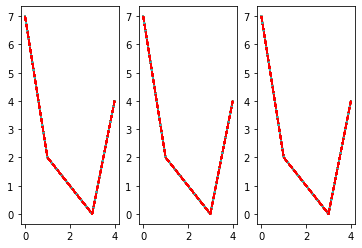

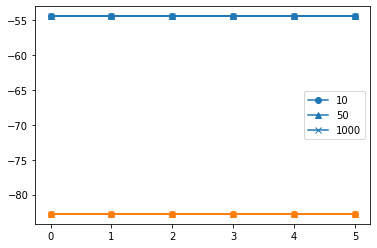

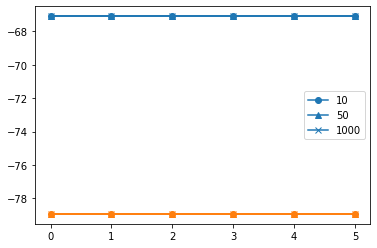

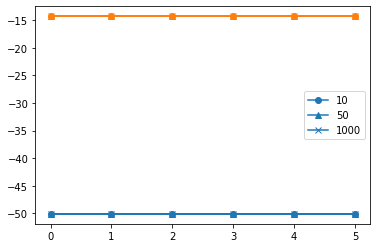

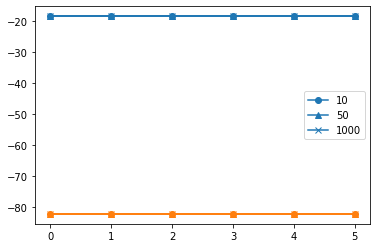

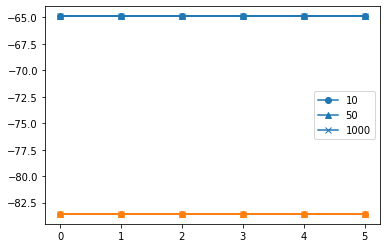

In [6]:
# test gain scaling with non-spiking neurons

gain_scales = [10, 50, 1000]
markers = ['o', '^', 'x']
lines = []
for jj, gain_scale in enumerate(gain_scales):

    converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: nengo.RectifiedLinear(1/gain_scale)},
    )
    net = converter.net
    nengo_input = converter.inputs[input]
    nengo_output = converter.outputs[dense_out]
    nengo_conv1 = converter.layer_map[conv1][0][0]

    nengo_conv1.ensemble.gain = nengo.dists.Choice([gain_scale])

    sim = nengo_dl.Simulator(net, minibatch_size=1, seed=0)
    sim.load_params("mnist_params")
    n_test = 5
    data = sim.predict({nengo_input: test_images[:n_test]})
    print(test_images.shape)
    print(test_labels.shape)

    print(data[nengo_output].shape)
    plt.figure(0)
    plt.subplot(1, len(gain_scales), jj+1)
    for ii in range(data[nengo_output].shape[1]):
        plt.plot(np.argmax(data[nengo_output][:, ii], axis=1))
    plt.plot(test_labels[:n_test].squeeze(), 'r--')

    for ii in range(data[nengo_output].shape[0]):
        plt.figure(ii+1)
        plt.gca().set_prop_cycle(None)
        #plt.subplot(1, len(gain_scales), jj+1)
        plt.plot(data[nengo_output][ii, ::5, :2], marker=markers[jj])

# make the legends 
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker=marker) for marker in markers]

for jj in range(data[nengo_output].shape[0]):
    plt.figure(jj+1)
    plt.legend(custom_lines, gain_scales)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
(10000, 30, 784)
(10000, 30, 1)
(5, 30, 10)
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
(10000, 30, 784)
(10000, 30, 1)
(5, 30, 10)
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
(10000, 30, 784)
(10000, 30, 1)
(5, 30, 10)


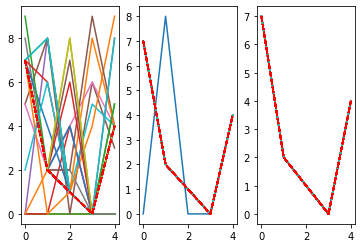

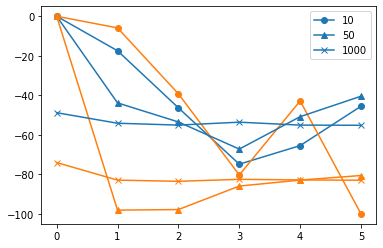

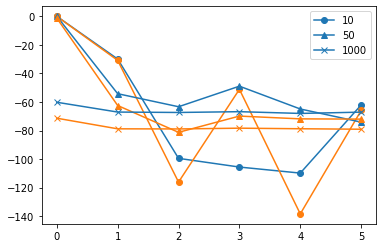

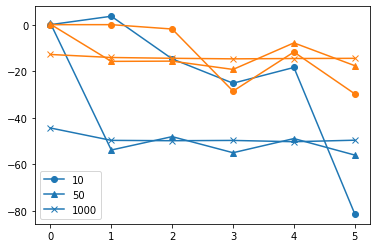

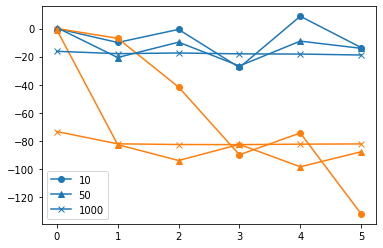

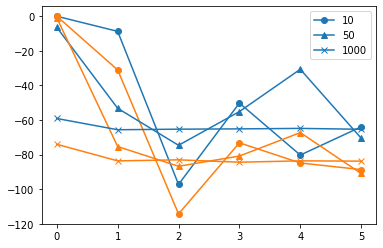

In [7]:
# test gain scaling with spiking neurons

gain_scales = [10, 50, 1000]
markers = ['o', '^', 'x']
lines = []
for jj, gain_scale in enumerate(gain_scales):

    converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear(1/gain_scale)},
    )
    net = converter.net
    nengo_input = converter.inputs[input]
    nengo_output = converter.outputs[dense_out]
    nengo_conv1 = converter.layer_map[conv1][0][0]

    nengo_conv1.ensemble.gain = nengo.dists.Choice([gain_scale])

    sim = nengo_dl.Simulator(net, minibatch_size=1, seed=0)
    sim.load_params("mnist_params")
    n_test = 5
    data = sim.predict({nengo_input: test_images[:n_test]})
    print(test_images.shape)
    print(test_labels.shape)

    print(data[nengo_output].shape)
    plt.figure(0)
    plt.subplot(1, len(gain_scales), jj+1)
    for ii in range(data[nengo_output].shape[1]):
        plt.plot(np.argmax(data[nengo_output][:, ii], axis=1))
    plt.plot(test_labels[:n_test].squeeze(), 'r--')

    for ii in range(data[nengo_output].shape[0]):
        plt.figure(ii+1)
        plt.gca().set_prop_cycle(None)
        #plt.subplot(1, len(gain_scales), jj+1)
        plt.plot(data[nengo_output][ii, ::5, :2], marker=markers[jj])

# make the legends 
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker=marker) for marker in markers]

for jj in range(data[nengo_output].shape[0]):
    plt.figure(jj+1)
    plt.legend(custom_lines, gain_scales)

In [19]:
# Using a converted ConvNet Keras network with a ReLU input layer in NengoDL

tf.random.set_seed(0)
input = tf.keras.Input(shape=(28, 28, 1), batch_size=minibatch_size)

relu = tf.keras.layers.Activation(tf.nn.relu)
relu_out = relu(input)

conv1 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    use_bias=False,
    activation=tf.nn.relu,
    data_format="channels_last"
)
conv1_out = conv1(relu_out)

flatten = tf.keras.layers.Flatten()(conv1_out)

dense = tf.keras.layers.Dense(units=10, use_bias=False)
dense_out = dense(flatten)

model = tf.keras.Model(inputs=input, outputs=dense_out)
converter = nengo_dl.Converter(
    model,
    swap_activations={tf.nn.relu: nengo.RectifiedLinear()},
)
net = converter.net
nengo_input = converter.inputs[input]
nengo_output = converter.outputs[dense_out]
nengo_conv1 = converter.layer_map[conv1][0][0]

nengo_conv1.ensemble.gain = nengo.dists.Choice([1])
with converter.net as net:
    net.config[nengo_relu.ensemble.neurons].trainable = False
    net.config[nengo_conv1.ensemble.neurons].trainable = False
    
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size, seed=0)

def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(
        y_true[:, -1], y_pred[:, -1])

sim.compile(loss={nengo_output: classification_accuracy})
print("accuracy before training:",
      sim.evaluate(test_images, {nengo_output: test_labels}, verbose=0)["loss"])

# run training
sim.compile(
    optimizer=tf.optimizers.RMSprop(0.001),
    loss={nengo_output: tf.losses.SparseCategoricalCrossentropy(from_logits=True)}
)
sim.fit(train_images, {nengo_output: train_labels}, epochs=10)

# save the parameters to file
sim.save_params("mnist_params")

sim.compile(loss={nengo_output: classification_accuracy})
print("accuracy after training:",
      sim.evaluate(test_images, {nengo_output: test_labels}, verbose=0)["loss"])

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
accuracy before training: 0.09570000000298023
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 43us/sample - loss: 3.2414 - probe_loss: 3.2414
Epoch 2/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0736 - probe_loss: 0.0736
Epoch 3/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0353 - probe_loss: 0.0353
Epoch 4/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0195 - probe_loss: 0.0195
Epoch 5/10
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0107 - probe_loss: 0.0107
Epoch 6/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0061 - probe_loss: 0.0061
Epoch 7/10
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0037 - probe_loss: 0.0037
Epoch 8/

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
(5, 30, 10)
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
(5, 30, 10)
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
(5, 30, 10)


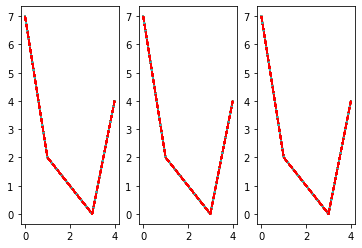

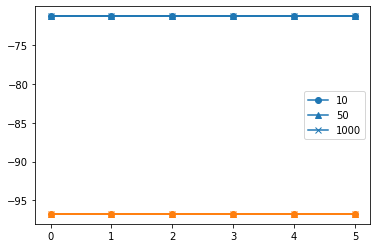

/home/tdewolf/Dropbox/code/nengo_dl/nengo_dl/simulator.py:1998: RuntimeWarning: Simulator with model=Model: <Network "model_3">, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  RuntimeWarning,
/home/tdewolf/Dropbox/code/nengo_dl/nengo_dl/simulator.py:1998: RuntimeWarning: Simulator with model=Model: <Network "model_4">, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  RuntimeWarning,


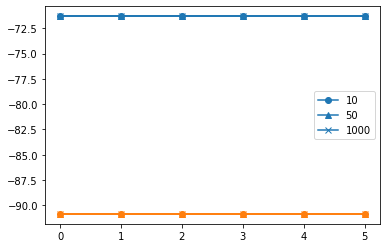

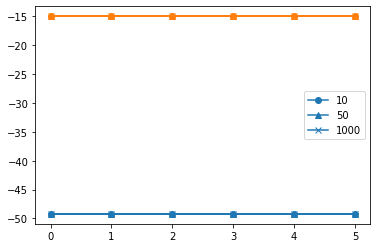

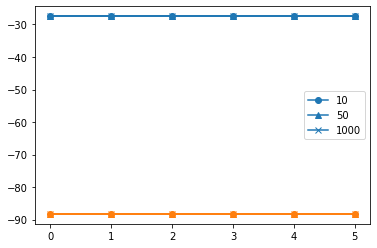

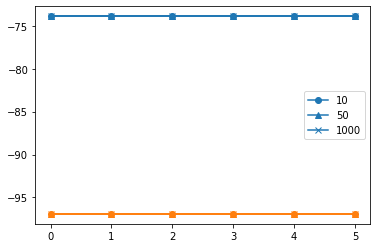

In [20]:
# test gain scaling with non-spiking neurons

gain_scales = [10, 50, 1000]
markers = ['o', '^', 'x']
lines = []
for jj, gain_scale in enumerate(gain_scales):

    converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: nengo.RectifiedLinear(1/gain_scale)},
    )
    net = converter.net
    nengo_input = converter.inputs[input]
    nengo_output = converter.outputs[dense_out]
    nengo_relu1 = converter.layer_map[relu][0][0]
    nengo_conv1 = converter.layer_map[conv1][0][0]

    nengo_relu1.ensemble.gain = nengo.dists.Choice([gain_scale])
    nengo_conv1.ensemble.gain = nengo.dists.Choice([gain_scale])

    sim = nengo_dl.Simulator(net, minibatch_size=1, seed=0)
    sim.load_params("mnist_params")
    n_test = 5
    data = sim.predict({nengo_input: test_images[:n_test]})

    print(data[nengo_output].shape)
    plt.figure(0)
    plt.subplot(1, len(gain_scales), jj+1)
    for ii in range(data[nengo_output].shape[1]):
        plt.plot(np.argmax(data[nengo_output][:, ii], axis=1))
    plt.plot(test_labels[:n_test].squeeze(), 'r--')

    for ii in range(data[nengo_output].shape[0]):
        plt.figure(ii+1)
        plt.gca().set_prop_cycle(None)
        #plt.subplot(1, len(gain_scales), jj+1)
        plt.plot(data[nengo_output][ii, ::5, :2], marker=markers[jj])

# make the legends 
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker=marker) for marker in markers]

for jj in range(data[nengo_output].shape[0]):
    plt.figure(jj+1)
    plt.legend(custom_lines, gain_scales)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
(10000, 30, 784)
(10000, 30, 1)
(5, 30, 10)
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
(10000, 30, 784)
(10000, 30, 1)
(5, 30, 10)
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
(10000, 30, 784)
(10000, 30, 1)
(5, 30, 10)


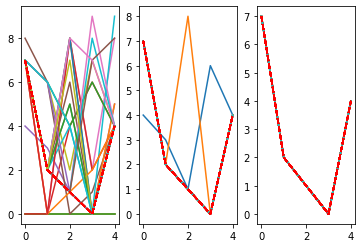

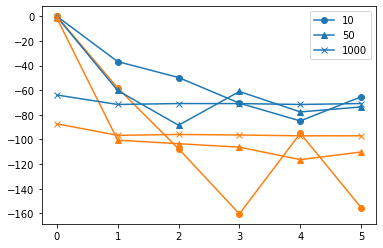

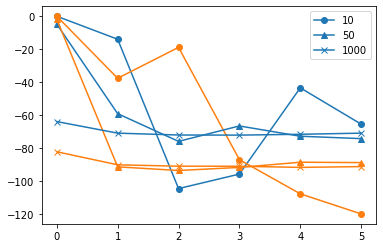

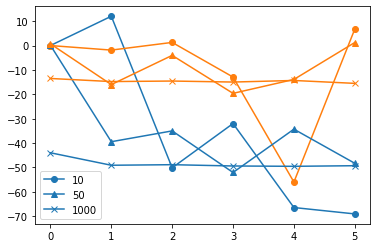

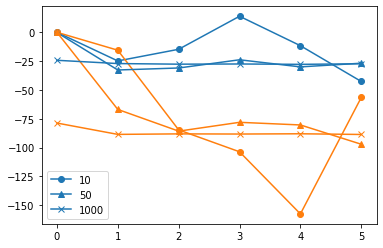

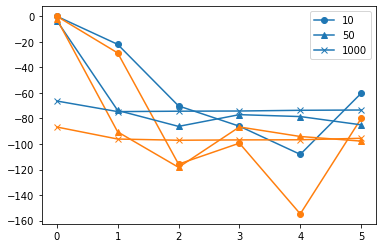

In [21]:
# test gain scaling with spiking neurons

gain_scales = [10, 50, 1000]
markers = ['o', '^', 'x']
lines = []
for jj, gain_scale in enumerate(gain_scales):

    converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear(1/gain_scale)},
    )
    net = converter.net
    nengo_input = converter.inputs[input]
    nengo_output = converter.outputs[dense_out]
    nengo_relu1 = converter.layer_map[relu][0][0]
    nengo_conv1 = converter.layer_map[conv1][0][0]
    
    nengo_relu1.ensemble.gain = nengo.dists.Choice([gain_scale])
    nengo_conv1.ensemble.gain = nengo.dists.Choice([gain_scale])
    
    sim = nengo_dl.Simulator(net, minibatch_size=1, seed=0)
    sim.load_params("mnist_params")
    n_test = 5
    data = sim.predict({nengo_input: test_images[:n_test]})
    print(test_images.shape)
    print(test_labels.shape)

    print(data[nengo_output].shape)
    plt.figure(0)
    plt.subplot(1, len(gain_scales), jj+1)
    for ii in range(data[nengo_output].shape[1]):
        plt.plot(np.argmax(data[nengo_output][:, ii], axis=1))
    plt.plot(test_labels[:n_test].squeeze(), 'r--')

    for ii in range(data[nengo_output].shape[0]):
        plt.figure(ii+1)
        plt.gca().set_prop_cycle(None)
        #plt.subplot(1, len(gain_scales), jj+1)
        plt.plot(data[nengo_output][ii, ::5, :2], marker=markers[jj])

# make the legends 
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker=marker) for marker in markers]

for jj in range(data[nengo_output].shape[0]):
    plt.figure(jj+1)
    plt.legend(custom_lines, gain_scales)